## BMI for the bionic arm

As a proof of concept we want to show that our bionic arm can replicate the actions performed by the monkey during a trial.

### Import

In [1]:
import numpy as np
from time import sleep, time
import _thread
from statistics import mode

from IPython.display import display, Markdown, clear_output
# widget packages
import ipywidgets as widgets
from sklearn.metrics import accuracy_score

#Import graphics
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
%matplotlib inline
import seaborn as sns
import matplotlib.patches as patches
from matplotlib.animation import FuncAnimation, writers
%matplotlib inline

from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import load_model
import pickle as pkl

import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
from utils.functions import *

In [2]:
# Plotting function
def display_testing_phase_results(conf_matrix, my_labels, errors_distribution, y_test, network_name='network', separators=False, annotate_matrix=True, save=True):
    n_outputs = len(my_labels)
    fig = plt.figure(figsize=(14, 9))
    fig.suptitle(f'Performances of {network_name} testing', fontsize=16)
    gs = gridspec.GridSpec(nrows=3, ncols=3)

    ax1 = fig.add_subplot(gs[:, :-1])
    ax1.set_title('Confusion matrix', fontsize=14)
    conf_matrix_norm = normalize(conf_matrix, axis=1, norm='l1')
    im = ax1.imshow(conf_matrix_norm, cmap=sns.cubehelix_palette(as_cmap=True, light=.98, gamma=0.75), vmin=0, vmax=1)

    ax1.vlines([i + 0.5 for i in range(n_outputs)], -0.5, n_outputs - 0.5, linewidth=2, colors='White')
    ax1.hlines([i + 0.5 for i in range(n_outputs)], -0.5, n_outputs - 0.5, linewidth=2, colors='White')
    plt.colorbar(im, fraction=0.046, pad=0.04)
    if annotate_matrix:
        rows, columns = conf_matrix.shape
        for i in range(rows):
            for j in range(columns):
                c = int(conf_matrix[i][j]) if conf_matrix[i][j].is_integer() else conf_matrix[i][j]
                if c > 0:
                    color = 'White' if conf_matrix_norm[i][j]>=.65 else 'Black'
                    ax1.text(j, i, str(round(c,0)), va='center', ha='center', c=color, fontsize=12)
    ax1.set_xticks(list(range(n_outputs)))
    ax1.set_yticks(list(range(n_outputs)))
    ax1.set_xticklabels(my_labels)
    ax1.set_yticklabels(my_labels)
    ax1.set_ylabel('true value', fontsize=12)
    ax1.set_xlabel('prediction', fontsize=12)
    if separators:
        seps = []
        past_label = my_labels[0]
        for i, l in enumerate(my_labels):
            l = str(l)
            if len(l) == 1 or l[0] != past_label:
                seps.append(i - 0.5)
            past_label = l[0]
        ax1.vlines(seps, -0.5, n_outputs - 0.5, linewidth=1, color='k')
        ax1.hlines(seps, -0.5, n_outputs - 0.5, linewidth=1, color='k')

    ax2 = fig.add_subplot(gs[0, -1])
    ax2.set_title('Distance from the diagonal', fontsize=14)
    x = list(errors_distribution.keys())
    x.sort()
    y = [errors_distribution[distance] for distance in x]
    ax2.step(x, y, where='mid', c='midnightblue')
    ax2.axvspan(-1.5, 1.5, alpha=0.4, color='palevioletred')
    x_max = min(max(list(errors_distribution.keys())), 10)
    lim = x_max if x_max%2 == 0 else x_max-1
    lim = min(lim, 10)
    ax2.set_xticks(list(range(-lim, lim+2, 2)))
    ax2.set_xlim(-x_max, x_max)
    ax2.set_yscale('log')
    ax2.set_ylabel('n errors', fontsize=12)
    ax2.set_xlabel('distance', fontsize=12, y=-10)
    
    e0 = errors_distribution[0]
    e1 = errors_distribution[1]+errors_distribution[-1]
    
    ax3 = fig.add_subplot(gs[1, -1])
    ax3.axis('off')
    ax3.text(0,0.9,f'Distance 0: {round(e0, 3)} [{round(e0/len(y_test)*100, 1)}%]', fontsize=11.5)
    ax3.text(0,0.8,f'Distance ±1: {round(e0+e1, 3)} [{round((e0+e1)/len(y_test)*100, 1)}%]', fontsize=11.5)


    plt.tight_layout(rect=[0, 0, 1, 0.96], pad=3.0)
    if save:
        fig.savefig(f'{PLOTS_FOLDER}/{network_name.replace(" ", "_")}_testing_results.png')
    plt.show()


In [3]:
WINDOW = 10
PATIENCE = 5

In [4]:
test_trials = pkl.load(open(f'../data/online/test_dict_{WINDOW}.pkl', 'rb'))

In [5]:
# Initialize model
state_model = load_model(f'../results/online/state_decoder_{WINDOW}.h5')
shape_model = load_model(f'../results/online/shape_decoder_{WINDOW}.h5')
size_model = load_model(f'../results/online/size_decoder_{WINDOW}.h5')

state_encoder = LabelEncoder()
state_encoder.fit_transform(np.load('../results/online/state_encoding.npy'))
shape_encoder = LabelEncoder()
shape_encoder.fit_transform(np.load('../results/online/shape_encoding.npy'))
size_encoder = LabelEncoder()
size_encoder.fit_transform(np.load('../results/online/size_encoding.npy'))

array([0, 1, 2, 3, 4, 5], dtype=int64)

# SIMULATION

In [6]:
# Global variables
[state_xmin, state_xmax] = np.load('../results/online/windows_state_min_max.npy')
[shape_xmin, shape_xmax] = np.load('../results/online/windows_shape_min_max.npy')
[size_xmin, size_xmax] = np.load('../results/online/windows_size_min_max.npy')
figures = []
pred_states = []
pred_shapes = []
pred_sizes = []

In [7]:
# Functions
def predict_state(window):
    global state_xmin, state_xmax, state_model, pred_states
    window = (window - state_xmin) / (state_xmax - state_xmin)
    pred = state_model.predict(window)
    pred_states.append(pred.argmax())
    
def predict_shape(window):
    global shape_xmin, shape_xmax, shape_model, pred_shapes
    window = (window - shape_xmin) / (shape_xmax - shape_xmin)
    pred = shape_model.predict(window)
    pred_shapes.append(pred.argmax())
    
def predict_size(window):
    global size_xmin, size_xmax, size_model, pred_sizes
    window = (window - size_xmin) / (size_xmax - size_xmin)
    pred = size_model.predict(window)
    pred_sizes.append(pred.argmax())
    
def draw_figure(index, avg_activations, boundaries):
    global figures
    width = WINDOW-1 if index >= WINDOW else index
    nbins = len(avg_activations)
    # Create figure and axes
    fig, ax = plt.subplots(figsize=(20,5))

    # Display the image    
    pre_line = avg_activations[:index-width]
    if not pre_line:
        pre_line = [avg_activations[0]]
    if index >= WINDOW:
        pre_line.append(pre_line[-1])
        pre_line_x = list(range(nbins))[:index-width]
        pre_line_x.append(pre_line_x[-1]+.5)
        ax.step(pre_line_x, pre_line, where='post', color='#1f77b4', alpha=0.5) # before filter


    red_line = avg_activations[index-width:index+1]
    red_line_x = list(range(nbins))[index-width:index+1]
    if index >= WINDOW:
        red_line.insert(0, pre_line[-1])
        red_line_x.insert(0, red_line_x[0]-.5)

    red_line.append(red_line[-1])      
    red_line_x.append(red_line_x[-1]+.5)
    ax.step(red_line_x, red_line, where='post', color='r', alpha=0.9) # under filter

    if index != nbins-1:
        post_line = avg_activations[index+1:]
        post_line_x = list(range(nbins))[index+1:]
        post_line.insert(0, red_line[-1])
        post_line_x.insert(0, post_line_x[0]-.5)
        ax.step(post_line_x, post_line, where='post', color='#1f77b4') # after filter

    # Create a Rectangle patch
    rect_border = patches.Rectangle((index-width-.5, 0), width+1, boundaries[1]*1.15, linewidth=1, edgecolor='r', facecolor='none')
    rect = patches.Rectangle((index-width-.5, 0), width+1, boundaries[1]*1.15, linewidth=1, edgecolor='none', facecolor='y', alpha=0.1)
    
    # Add the patch to the Axes
    ax.add_patch(rect)
    ax.add_patch(rect_border)

    plt.xlim(-2, len(avg_activations)+2)
    figures.append(fig)
    
def show_figure():
    global figures
    sleep(.5)
    clear_output()
    fig = figures[-1]
    plt.show()
    


In [11]:
out = widgets.Output()

def start_simulation(b):
    global figures, pred_states, pred_shapes, pred_sizes
    figures.clear()
    pred_states.clear()
    pred_shapes.clear()
    pred_sizes.clear()
    
    with out:
        action = b.description
        
        # select the desired trial
        trial = test_trials[action]['trial']#[:, 80:100]
        (channels, nbins) = trial.shape
 
        trial_state = [x.strip() for x in test_trials[action]['states']]
        obj_shape = test_trials[action]['obj_shape']
        obj_size = test_trials[action]['obj_size']
        
        phase_dict = {
            'Waiting': np.where(np.isin(trial_state, ['Start', 'Rest', 'Motor', 'FixLOn', 'Fix']))[0],
            'Cue': np.where(np.isin(trial_state, ['Cue']))[0],
            'Planning': np.where(np.isin(trial_state, ['Mem']))[0],
            'Movement': np.where(np.isin(trial_state, ['React', 'Go']))[0],
            'Hold': np.where(np.isin(trial_state, ['Hold', 'Rew']))[0],
            'End': np.where(np.isin(trial_state, ['Intert', 'End']))[0]
        }

        new_states = ['Waiting', 'Cue', 'Planning', 'Movement', 'Hold', 'End']
        for phase in new_states: #important to read them in chronological order
            phase_idx = phase_dict[phase]
            for idx in phase_idx:
                trial_state[idx] = phase
                
        avg_activations = [channels.mean() for channels in trial.T]
        boundaries = (min(avg_activations), max(avg_activations))
        
        print(f'Simulating {obj_shape} {obj_size}..')
        results = []
        for index in range(0, nbins-1, 1):
            start_t = time()
            _thread.start_new_thread(draw_figure, (index, avg_activations, boundaries))
            
            window = trial[np.newaxis, :, max(0, index-0):index+1]
            _thread.start_new_thread(predict_state, (window,))
            _thread.start_new_thread(predict_shape, (window,))
            _thread.start_new_thread(predict_size, (window,))
            #_thread.start_new_thread(show_figure, ())
            
            sleep(0.5 - 0.1)
            clear_output()
            print(f'Simulating {obj_shape} {obj_size}..')
            fig = figures[-1]
            plt.show()
            try:
                r1 = state_encoder.classes_[mode(pred_states[max(-PATIENCE, -len(pred_states)):])]
                r2 = shape_encoder.classes_[mode(pred_shapes[max(-PATIENCE, -len(pred_states)):])]
                r3 = size_encoder.classes_[mode(pred_sizes[max(-PATIENCE, -len(pred_states)):])]
                results.append((r1, r2, r3))
            print(f'[{index}] - '
                  f'Next state: {r1}; '
                  f'Shape: {r2}; '
                  f'Size: {r3} -- {round(time()-start_t, 3)}s')
            
        temp = np.array(results)
        print(f'Accuracy score -- State: {accuracy_score(trial_state[1:], temp[:, 0])};  Shape: {accuracy_score([obj_shape]*temp.shape[0], temp[:, 1])};  Size: {accuracy_score([obj_size]*temp.shape[0], temp[:, 2])}')
        
        # Metrics
        conf_matrix, my_labels = my_confusion_matrix(temp[:, 0], trial_state[1:], labels=new_states, return_labels=True)
        errors_distribution = distance_from_diagonal(conf_matrix)

        # Displaying
        display_testing_phase_results(conf_matrix, my_labels, errors_distribution, trial_state, f'states decoder', save=False)
        
        # Metrics
        conf_matrix, my_labels = my_confusion_matrix(temp[:, 1], [obj_shape]*temp.shape[0], labels=shape_encoder.classes_, return_labels=True)
        errors_distribution = distance_from_diagonal(conf_matrix)

        # Displaying
        display_testing_phase_results(conf_matrix, my_labels, errors_distribution, trial_state, f'shape decoder', save=False)
        
        # Metrics
        conf_matrix, my_labels = my_confusion_matrix(temp[:, 2], [obj_size]*temp.shape[0], labels=size_encoder.classes_, return_labels=True)
        errors_distribution = distance_from_diagonal(conf_matrix)

        # Displaying
        display_testing_phase_results(conf_matrix, my_labels, errors_distribution, trial_state, f'size decoder', save=False)

  File "C:/Users/feder/AppData/Local/Temp/xpython_5632/887212605.py", line 61
    print(f'[{index}] - '
    ^
SyntaxError: invalid syntax



In [12]:
b_ring = widgets.Button(description='rings')
b_cube = widgets.Button(description='cubes')
b_ball = widgets.Button(description='balls')
b_hCylinder = widgets.Button(description='hCylinder')
b_box = widgets.Button(description='boxes')
b_vCylinder = widgets.Button(description='vCylinder')

b_ring.on_click(start_simulation)
b_cube.on_click(start_simulation)
b_ball.on_click(start_simulation)
b_hCylinder.on_click(start_simulation)
b_box.on_click(start_simulation)
b_vCylinder.on_click(start_simulation)

# displaying button and its output together
print('Select a simulation to start..')
widgets.VBox([widgets.HBox([b_ring, b_cube, b_ball, b_hCylinder, b_box, b_vCylinder]), out])

Select a simulation to start..


In [13]:
 def sliding_window(my_window, my_states, my_shape, my_size, w_size=10):
        p_window = []
        next_state = []
        shape = []
        size = []
        (n_channels, n_steps) = my_window.shape
        for time_step in range(n_steps):
            if time_step < w_size-1:
                sliced_window = np.zeros((n_channels, w_size-time_step-1))
                sliced_window = np.hstack((sliced_window, my_window[:, :time_step+1]))
            else:
                sliced_window = my_window[:, time_step-w_size+1:time_step+1]
                
            p_window.append(sliced_window.astype('float32'))
            if time_step == n_steps-1:
                next_state.append('End')
            else:
                next_state.append(my_states[time_step+1].strip())
            shape.append(my_shape)
            size.append(my_size)

        return np.array(p_window, dtype='float32'), next_state, shape, size

In [14]:
action = 'balls'
p_window, trial_state, obj_shape, obj_size = sliding_window(test_trials[action]['trial'], test_trials[action]['states'], test_trials[action]['obj_shape'], test_trials[action]['obj_size'])
#trial_state = np.array(trial_state)
obj_shape = np.array(obj_shape)
obj_size = np.array(obj_size)
print(obj_shape[0], obj_size[0])

phase_dict = {
    'Waiting': np.where(np.isin(trial_state, ['Start', 'Rest', 'Motor', 'FixLOn', 'Fix']))[0],
    'Cue': np.where(np.isin(trial_state, ['Cue']))[0],
    'Planning': np.where(np.isin(trial_state, ['Mem']))[0],
    'Movement': np.where(np.isin(trial_state, ['React', 'Go']))[0],
    'Hold': np.where(np.isin(trial_state, ['Hold', 'Rew']))[0],
    'End': np.where(np.isin(trial_state, ['Intert', 'End']))[0]
}

new_states = ['Waiting', 'Cue', 'Planning', 'Movement', 'Hold', 'End']
for phase in new_states: #important to read them in chronological order
    phase_idx = phase_dict[phase]
    for idx in phase_idx:
        trial_state[idx] = phase
        
[xmin, xmax] = np.load('../results/online/windows_state_min_max.npy')
X = (p_window.astype('float32') - xmin) / (xmax - xmin)

balls 2


# STATE

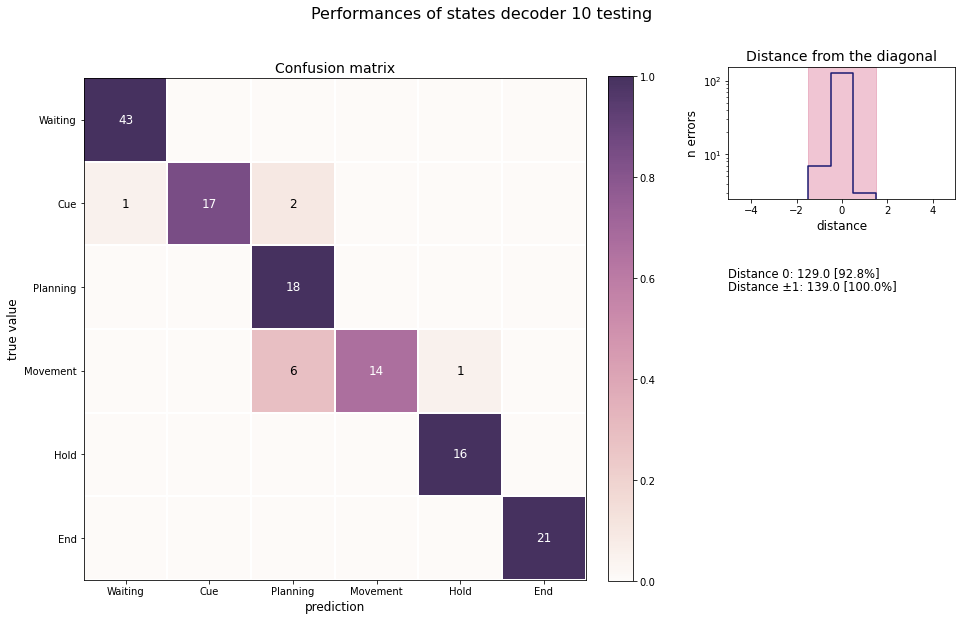

In [15]:
#[xmin, xmax] = np.load('../results/online/windows_state_min_max.npy')
#X = (p_window.astype('float32') - xmin) / (xmax - xmin)

# Predicting
prediction = state_model.predict(X)

# Metrics
conf_matrix, my_labels = my_confusion_matrix(state_encoder.inverse_transform(prediction.argmax(axis=1)), trial_state, labels=new_states, return_labels=True)
errors_distribution = distance_from_diagonal(conf_matrix)

# Displaying
display_testing_phase_results(conf_matrix, my_labels, errors_distribution, trial_state, f'states decoder {WINDOW}', save=False)

# Shape

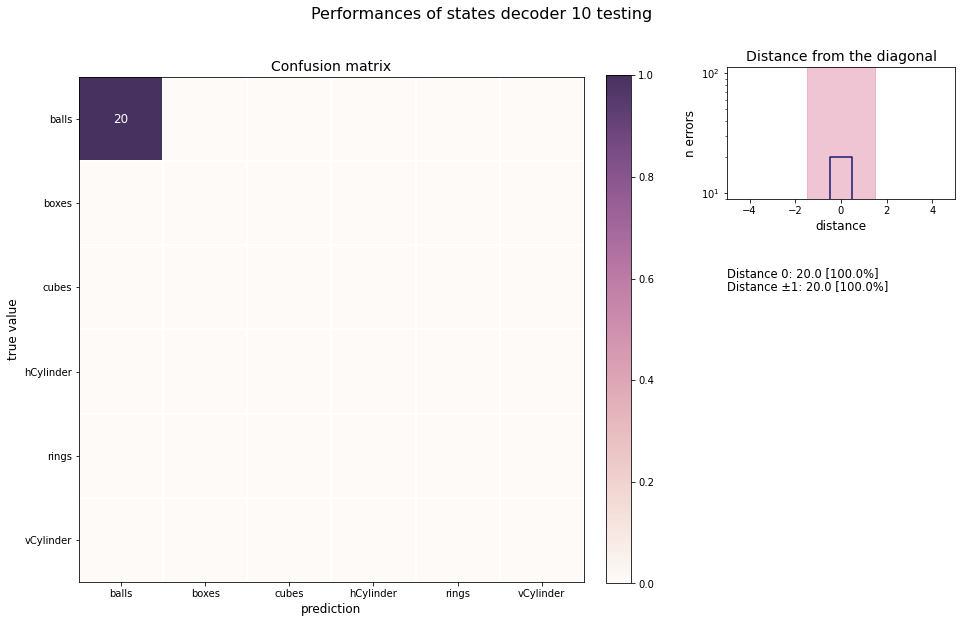

In [16]:
#[xmin, xmax] = np.load('../results/online/windows_state_min_max.npy')
#X = (p_window.astype('float32') - xmin) / (xmax - xmin)

to_keep = np.isin(trial_state, ['Cue', 'Mem', 'React', 'Go'])

# Predicting
prediction = shape_model.predict(X[to_keep])

# Metrics
conf_matrix, my_labels = my_confusion_matrix(shape_encoder.inverse_transform(prediction.argmax(axis=1)), obj_shape[to_keep], labels=shape_encoder.classes_, return_labels=True)
errors_distribution = distance_from_diagonal(conf_matrix)

# Displaying
display_testing_phase_results(conf_matrix, my_labels, errors_distribution, obj_shape[to_keep], f'states decoder {WINDOW}', save=False)

# Size

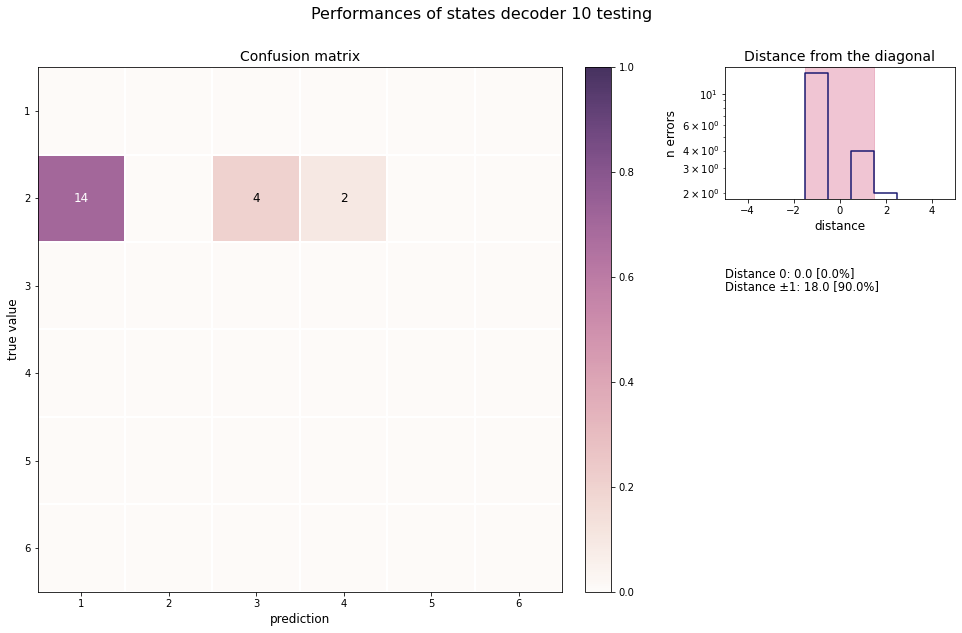

In [17]:
#[xmin, xmax] = np.load('../results/online/windows_size_min_max.npy')
#X = (p_window.astype('float32') - xmin) / (xmax - xmin)

to_keep = np.isin(trial_state, ['Cue', 'Mem', 'React', 'Go'])

# Predicting
prediction = size_model.predict(X[to_keep])

# Metrics
conf_matrix, my_labels = my_confusion_matrix(size_encoder.inverse_transform(prediction.argmax(axis=1)), obj_size[to_keep], labels=size_encoder.classes_, return_labels=True)
errors_distribution = distance_from_diagonal(conf_matrix)

# Displaying
display_testing_phase_results(conf_matrix, my_labels, errors_distribution, obj_size[to_keep], f'states decoder {WINDOW}', save=False)